# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

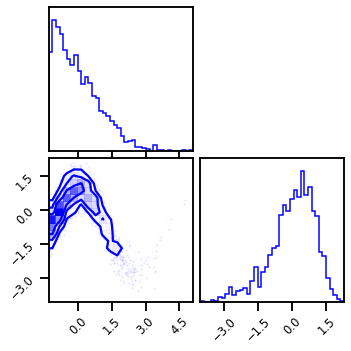

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
seed = 123
n_samples = 2_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [4]:
X = jnp.array(data, dtype=np.float32)

## Model

### Layer 1 - Spline Transformation

In [5]:
from rbig_jax.transforms.parametric.splines import InitPiecewiseRationalQuadraticCDF

In [6]:
# spline parameters
range_min = -10.0
range_max = 10.0
boundary_slopes = "identity"
n_bins = 10
n_features = 2
identity_init = True
min_knot_slope = 1e-4
min_bin_size = 1e-4
shape = (2,)
key = jax.random.PRNGKey(123)

In [7]:
init_rsq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    min_bin_size=min_bin_size,
    min_knot_slope=min_knot_slope,
)

rqs_bijector = init_rsq_f(key, n_features)

#### Forward Transformation

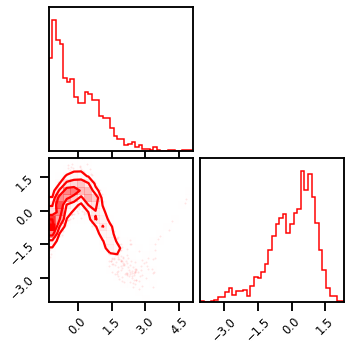

In [8]:
X_l1 = rqs_bijector.forward(X)

# plot
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)

#### Inverse Transformation

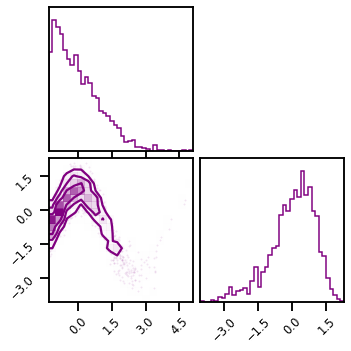

In [9]:
X_approx = rqs_bijector.inverse(X_l1)

# plot
fig = corner.corner(X_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

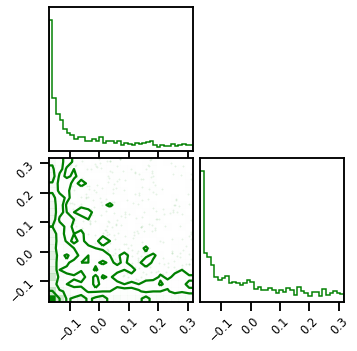

In [10]:
X_ldj = rqs_bijector.forward_log_det_jacobian(X)

# plot
fig = corner.corner(X_ldj, color="green", hist_bin_factor=2)

### Layer II - HouseHolder Reflections

In [11]:
from rbig_jax.transforms.parametric.householder import InitHouseHolder

# layer parameters
n_reflections = 10

init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

#### Forward Transformation

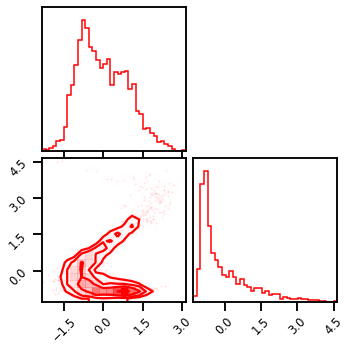

In [12]:
X_l2 = hh_bijector.forward(X_l1)

# plot
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

#### Inverse Transformation

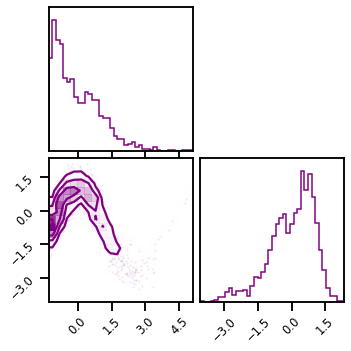

In [13]:
X_l1_approx = hh_bijector.inverse(X_l2)

# plot
fig = corner.corner(X_l1_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

In [14]:
X_l2_ldj = hh_bijector.forward_log_det_jacobian(X_l1)

chex.assert_equal(X_l2_ldj.min(), X_l2_ldj.max())

## Chaining Transformations

In [15]:
from typing import Tuple
from chex import Array, dataclass
from rbig_jax.transforms.base import cascade_forward_and_log_det, cascade_inverse_and_log_det


#### Forward Transformation

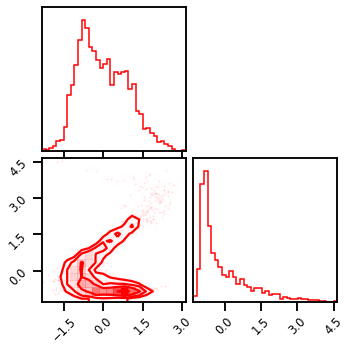

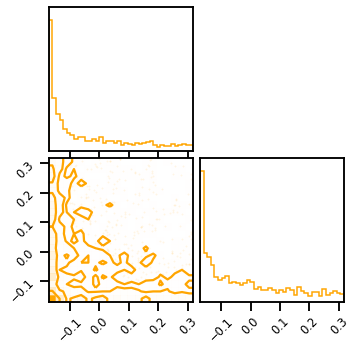

In [16]:
# initialize list of bijectors
bijectors = [
    rqs_bijector,
    hh_bijector
]

# cascade the transform
X_l2, X_l2_ldj = cascade_forward_and_log_det(bijectors, X)

# plot latent space
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l2_ldj, color="orange", hist_bin_factor=2)

#### Inverse Transformation

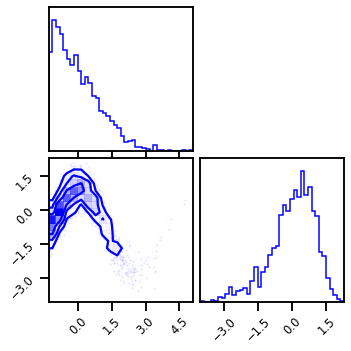

In [17]:
# initialize list of bijectors
bijectors = [
    rqs_bijector,
    hh_bijector
]

# cascade the transform
X_approx, _ = cascade_inverse_and_log_det(bijectors, X_l2)

# plot latent space
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

### Convenience Function

In [18]:
from typing import List, Iterable
from rbig_jax.transforms.base import BijectorChain

In [19]:
# initialize chain
chain_bijectors = BijectorChain(bijectors=bijectors)

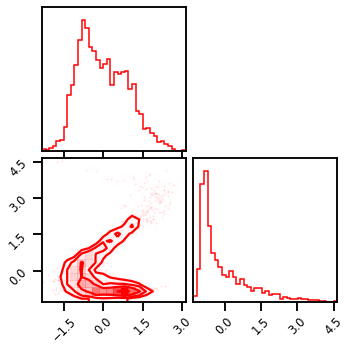

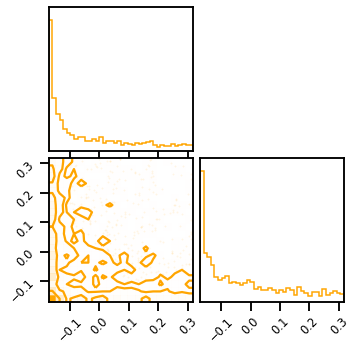

In [20]:
# cascade the transform
X_l2, X_l2_ldj = chain_bijectors.forward_and_log_det(X)

# plot latent space
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l2_ldj, color="orange", hist_bin_factor=2)

## Training

In [21]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 128
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

In [22]:
# Rational Quadratic Spline Transformation
init_rsq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    min_bin_size=min_bin_size,
    min_knot_slope=min_knot_slope,
)

rqs_bijector = init_rsq_f(key, n_features)

# Householder Transformation
n_reflections = 4
init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

# create chain
bijectors = [hh_bijector, rqs_bijector, hh_bijector]
chain_bijectors = BijectorChain(bijectors=bijectors)

### Loss Function

In [23]:
import jax.numpy as jnp
from rbig_jax.training import init_log_prob
from rbig_jax.loss import init_nll_loss
from distrax._src.distributions.normal import Normal

# init base distribtion (Gaussian)
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

# create log probability
log_prob = init_log_prob(base_dist)

# create loss function
nll_loss = init_nll_loss(log_prob)

### Optimizers

In [24]:
from jax.experimental import optimizers
from rbig_jax.training import init_train_op, train_model


lr = 0.005
optimizer = optimizers.adam
jitted = True
epochs = 500

# initialize training procedure
train_op, opt_params = init_train_op(
    chain_bijectors, nll_loss, optimizer, lr=lr, jitted=jitted
)

### Training Loop

In [25]:

# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 500/500 [00:16<00:00, 30.61it/s, loss=2.2762]


## Results

#### Losses

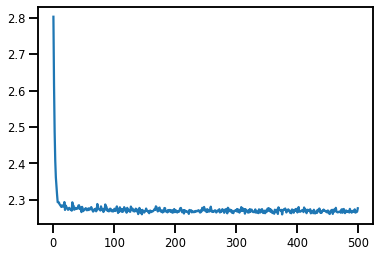

In [26]:
plt.plot(losses)

#### Latent Space

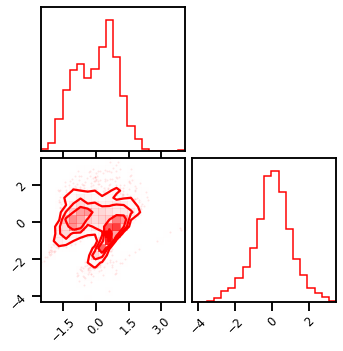

In [27]:
# X_trans = final_bijector.forward(data)
X_trans, _ = final_bijector.forward_and_log_det(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transformation

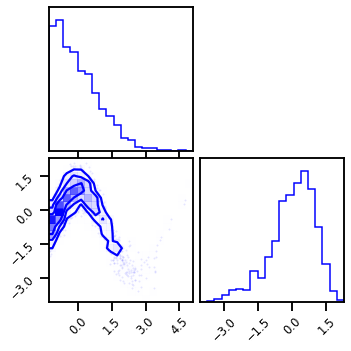

In [28]:
X_approx, _ = final_bijector.inverse_and_log_det(X_trans)

fig = corner.corner(X_approx, color="Blue")

## More Layers

In [29]:
# Rational Quadratic Spline Transformation
init_rsq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=10,
    range_min=-10,
    range_max=10,
    boundary_slopes="identity",
    identity_init=True,
    min_bin_size=1e-4,
    min_knot_slope=1e-4,
)
# Householder Transformation
n_reflections = 2
init_func = InitHouseHolder(n_reflections=n_reflections)

# create keys for all inits
n_layers = 5
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers)

for irng in layer_rngs:
    
    # create keys for all inits
    bijectors.append(init_rsq_f(irng, n_features))
    
    # create keys for all inits
    bijectors.append(init_func(hh_rng, n_features))

# create chain
chain_bijectors = BijectorChain(bijectors=bijectors)

### Retrain

In [30]:
# initialize training procedure
lr = 0.005
optimizer = optimizers.adam
jitted = True
epochs = 500

train_op, opt_params = init_train_op(
    chain_bijectors, nll_loss, optimizer, lr=lr, jitted=jitted
)


# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 500/500 [00:36<00:00, 13.57it/s, loss=1.8723]


### Results

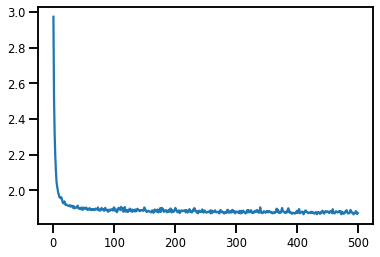

In [31]:
plt.plot(losses)

#### Latent Space

CPU times: user 1.22 s, sys: 28 ms, total: 1.24 s
Wall time: 1.2 s


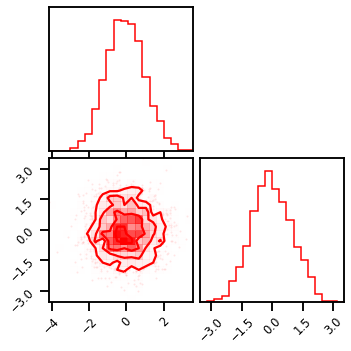

In [32]:
%%time

X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transformation

CPU times: user 1.29 s, sys: 25.2 ms, total: 1.32 s
Wall time: 1.26 s


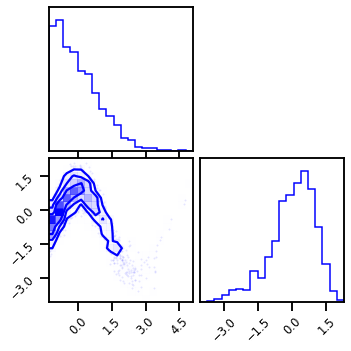

In [33]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Gradient

In [34]:
np.sum(np.isnan(X_ldj))

0

69


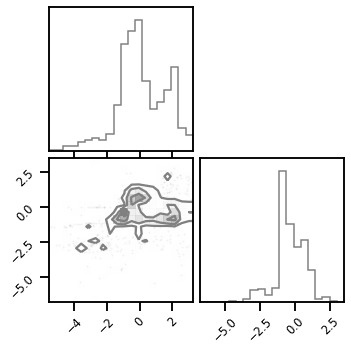

In [35]:
X_ldj = final_bijector.forward_log_det_jacobian(X_trans)
n_nans = np.sum(np.isnan(X_ldj))
print(n_nans)
X_ldj = jnp.where(jnp.isfinite(X_ldj), X_ldj, 0.0)
# print(X_ldj.shape)
# X_ldj = X_ldj[~np.isnan(X_ldj), :]
# print(X_ldj.shape)
fig = corner.corner(X_ldj, color="gray")